# install libraries

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Import helper libraries

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-19pchbvs because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# connect to snowflake

In [2]:
snowflake.get_connection(connection_name="TTH_REV_OPT_CXN")
data = get_dataframe("BOOKINGS_TRANSFORMED")
data

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7fbdcc26fe50>
Please close the connection after use!
Reading dataframe from snowflake native connector


,ARRIVAL_DATE_TRANSFORMED,RESERVATION_STATUS_DATE_TRANSFORMED,HOTEL,IS_CANCELED,LEAD_TIME,ARRIVAL_DATE_YEAR,MONTH,ARRIVAL_DATE_WEEK_NUMBER,ARRIVAL_DATE_DAY_OF_MONTH,EXPECTED_ARRIVAL_DATE,RESERVATION_STATUS,RESERVATION_STATUS_DATE,TOTAL_STAY_NIGHTS,TALLY_DAYS,STAYS_IN_WEEKEND_NIGHTS,STAYS_IN_WEEK_NIGHTS,ADULTS,CHILDREN,BABIES,TOTAL_GUESTS,AVG_ROOMS_PER_NIGHT,TOTAL_ROOM_NIGHTS,MEAL,COUNTRY,MARKET_SEGMENT,DISTRIBUTION_CHANNEL,PREVIOUS_CANCELLATIONS,PREVIOUS_BOOKINGS_NOT_CANCELED,RESERVED_ROOM_TYPE,ASSIGNED_ROOM_TYPE,DEPOSIT_TYPE,DAYS_IN_WAITING_LIST,CUSTOMER_TYPE,ADR,TRANSCATION_IDS,CUST_ID,ROOM_LIMIT
0,2023-08-03,2023-08-06,City Hotel,0,86,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,3,0,0,3,1,3,BB,DEU,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,195.00,B20230803343215,C0106952,135
1,2023-08-02,2023-08-06,Resort Hotel,0,10,2023,8,31,2,02-08-2023,Check.Out,06-08-2023,4,4.0,0,4,2,0,0,2,1,4,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,228.50,B20230802911470,C0106953,360
2,2023-08-03,2023-08-06,City Hotel,0,180,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,2,0,0,2,1,3,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,80.10,B20230803481168,C0106954,460
3,2023-07-29,2023-08-06,City Hotel,0,148,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,121.88,B20230729335744,C0106955,460
4,2023-08-05,2023-08-06,City Hotel,0,0,2023,8,31,5,05-08-2023,Check.Out,06-08-2023,1,1.0,0,1,1,0,0,1,1,1,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,179.00,B20230805458332,C0106956,460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-04,2023-08-06,City Hotel,0,11,2023,8,31,4,04-08-2023,Check.Out,06-08-2023,2,2.0,0,2,2,0,0,2,1,2,SC,SLV,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,160.00,B20230804347306,C0106947,460
109707,2023-07-30,2023-08-06,Resort Hotel,0,300,2023,7,31,30,30-07-2023,Check.Out,06-08-2023,7,7.0,2,5,2,0,0,2,1,7,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,149.81,B20230730168488,C0106948,360
109708,2023-07-29,2023-08-06,City Hotel,0,69,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,RUS,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,126.00,B20230729444159,C0106949,460
109709,2023-08-01,2023-08-06,City Hotel,0,147,2023,8,31,1,01-08-2023,Check.Out,06-08-2023,5,5.0,0,5,3,0,0,3,1,5,BB,SWE,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,175.50,B20230801923755,C0106950,135


# removing Canceletions and no-shows and keep City hotel data only


In [4]:
def update_values(row):
    if row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'A':
        return 300
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'E':
        return 20
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'A':
        return 250
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'E':
        return 60
    else:
        pass

In [5]:
data.columns = map(lambda x: str(x).lower(), data.columns)

In [6]:
data['room_limit'] = data.apply(update_values, axis=1)
data

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,transcation_ids,cust_id,room_limit
0,2023-08-03,2023-08-06,City Hotel,0,86,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,3,0,0,3,1,3,BB,DEU,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,195.00,B20230803343215,C0106952,80
1,2023-08-02,2023-08-06,Resort Hotel,0,10,2023,8,31,2,02-08-2023,Check.Out,06-08-2023,4,4.0,0,4,2,0,0,2,1,4,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,228.50,B20230802911470,C0106953,250
2,2023-08-03,2023-08-06,City Hotel,0,180,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,2,0,0,2,1,3,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,80.10,B20230803481168,C0106954,300
3,2023-07-29,2023-08-06,City Hotel,0,148,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,121.88,B20230729335744,C0106955,300
4,2023-08-05,2023-08-06,City Hotel,0,0,2023,8,31,5,05-08-2023,Check.Out,06-08-2023,1,1.0,0,1,1,0,0,1,1,1,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,179.00,B20230805458332,C0106956,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-04,2023-08-06,City Hotel,0,11,2023,8,31,4,04-08-2023,Check.Out,06-08-2023,2,2.0,0,2,2,0,0,2,1,2,SC,SLV,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,160.00,B20230804347306,C0106947,300
109707,2023-07-30,2023-08-06,Resort Hotel,0,300,2023,7,31,30,30-07-2023,Check.Out,06-08-2023,7,7.0,2,5,2,0,0,2,1,7,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,149.81,B20230730168488,C0106948,250
109708,2023-07-29,2023-08-06,City Hotel,0,69,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,RUS,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,126.00,B20230729444159,C0106949,300
109709,2023-08-01,2023-08-06,City Hotel,0,147,2023,8,31,1,01-08-2023,Check.Out,06-08-2023,5,5.0,0,5,3,0,0,3,1,5,BB,SWE,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,175.50,B20230801923755,C0106950,80


In [10]:
data.columns

Index(['arrival_date_transformed', 'reservation_status_date_transformed',
       'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'expected_arrival_date', 'reservation_status',
       'reservation_status_date', 'total_stay_nights', 'tally_days',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'total_guests', 'avg_rooms_per_night', 'total_room_nights',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr', 'transcation_ids',
       'cust_id', 'room_limit'],
      dtype='object')

In [11]:
df = data[(data['is_canceled'] == 0) & (data['reservation_status'] !='No-Show')] 
df

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,transcation_ids,cust_id,room_limit
0,2023-08-03,2023-08-06,City Hotel,0,86,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,3,0,0,3,1,3,BB,DEU,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,195.00,B20230803343215,C0106952,80
1,2023-08-02,2023-08-06,Resort Hotel,0,10,2023,8,31,2,02-08-2023,Check.Out,06-08-2023,4,4.0,0,4,2,0,0,2,1,4,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,228.50,B20230802911470,C0106953,250
2,2023-08-03,2023-08-06,City Hotel,0,180,2023,8,31,3,03-08-2023,Check.Out,06-08-2023,3,3.0,0,3,2,0,0,2,1,3,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,80.10,B20230803481168,C0106954,300
3,2023-07-29,2023-08-06,City Hotel,0,148,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,121.88,B20230729335744,C0106955,300
4,2023-08-05,2023-08-06,City Hotel,0,0,2023,8,31,5,05-08-2023,Check.Out,06-08-2023,1,1.0,0,1,1,0,0,1,1,1,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,179.00,B20230805458332,C0106956,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-04,2023-08-06,City Hotel,0,11,2023,8,31,4,04-08-2023,Check.Out,06-08-2023,2,2.0,0,2,2,0,0,2,1,2,SC,SLV,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,160.00,B20230804347306,C0106947,300
109707,2023-07-30,2023-08-06,Resort Hotel,0,300,2023,7,31,30,30-07-2023,Check.Out,06-08-2023,7,7.0,2,5,2,0,0,2,1,7,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,149.81,B20230730168488,C0106948,250
109708,2023-07-29,2023-08-06,City Hotel,0,69,2023,7,30,29,29-07-2023,Check.Out,06-08-2023,8,8.0,2,6,2,0,0,2,1,8,SC,RUS,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,126.00,B20230729444159,C0106949,300
109709,2023-08-01,2023-08-06,City Hotel,0,147,2023,8,31,1,01-08-2023,Check.Out,06-08-2023,5,5.0,0,5,3,0,0,3,1,5,BB,SWE,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,175.50,B20230801923755,C0106950,80


In [12]:
df.groupby(['hotel','market_segment','reserved_room_type']).agg({'adr':'mean','reservation_status_date_transformed':'count'})


adr  \
hotel        market_segment reserved_room_type               
City Hotel   Aviation       A                    96.503608   
                            D                   107.713951   
                            E                   159.250000   
             Complementary  A                    45.840909   
                            D                    25.000000   
                            E                    55.000000   
             Corporate      A                    80.056789   
                            D                   100.689130   
                            E                   114.798295   
             Direct         A                   107.756930   
                            D                   132.383522   
                            E                   164.454444   
             Groups         A                    86.892940   
                            D                    87.340441   
                            E                    80.000000   
             Offline TA/TO  A                    91.273987   
                            D                    90.301959   
                            E                   133.371644   
             Online TA      A                   106.477667   
                            D                   136.476930   
                            E                   169.355059   
Resort Hotel Complementary  A                    21.226923   
                            D                    41.216667   
                            E                     7.333333   
             Corporate      A                    49.700175   
                            D                    67.398478   
                            E                    61.588545   
             Direct         A                    84.610434   
                            D                   116.982329   
                            E                   118.980300   
             Groups         A                    67.339807   
                            D                    74.881529   
                            E                    87.092028   
             Offline TA/TO  A                    64.219800   
                            D                    85.303927   
                            E                    97.511393   
             Online TA      A                    90.874218   
                            D                   113.257346   
                            E                   117.962164   

                                                reservation_status_date_transformed  
hotel        market_segment reserved_room_type                                       
City Hotel   Aviation       A                                                    97  
                            D                                                    81  
                            E                                                     2  
             Complementary  A                                                    22  
                            D                                                     4  
                            E                                                     2  
             Corporate      A                                                  2074  
                            D                                                   138  
                            E                                                    88  
             Direct         A                                                  3147  
                            D                                                   900  
                            E                                                   405  
             Groups         A                                                  4132  
                            D                                                    68  
                            E                                                     2  
             Offline TA/TO  A                     

In [13]:
data = df[(df.market_segment != 'Complementary') ]
data = data[(data.reserved_room_type == 'A') |(data.reserved_room_type == 'D') | (data.reserved_room_type == 'E')]
data.reserved_room_type.value_counts()


reserved_room_type
A    50872
D    12855
E     4486
Name: count, dtype: int64

In [14]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68213 entries, 0 to 109710
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   arrival_date_transformed             68213 non-null  object 
 1   reservation_status_date_transformed  68213 non-null  object 
 2   hotel                                68213 non-null  object 
 3   is_canceled                          68213 non-null  int8   
 4   lead_time                            68213 non-null  int16  
 5   arrival_date_year                    68213 non-null  int16  
 6   month                                68213 non-null  int8   
 7   arrival_date_week_number             68213 non-null  int8   
 8   arrival_date_day_of_month            68213 non-null  int8   
 9   expected_arrival_date                68213 non-null  object 
 10  reservation_status                   68213 non-null  object 
 11  reservation_status_date         

In [15]:
data_backup = data.copy()

In [16]:
hotels = data['hotel'].unique()
room_types = data['reserved_room_type'].unique()

In [17]:
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
data_to_transform = data[['hotel','reserved_room_type','arrival_date_transformed','total_rns','adr', 'room_limit']]
data_to_transform

,hotel,reserved_room_type,arrival_date_transformed,total_rns,adr,room_limit
0,City Hotel,D,2023-08-03,3,195.00,80
1,Resort Hotel,A,2023-08-02,4,228.50,250
2,City Hotel,A,2023-08-03,3,80.10,300
3,City Hotel,A,2023-07-29,8,121.88,300
4,City Hotel,A,2023-08-05,1,179.00,300
...,...,...,...,...,...,...
109706,City Hotel,A,2023-08-04,2,160.00,300
109707,Resort Hotel,A,2023-07-30,7,149.81,250
109708,City Hotel,A,2023-07-29,8,126.00,300
109709,City Hotel,D,2023-08-01,5,175.50,80


In [18]:
import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

[Row(status='Statement executed successfully.')]

# Create a new dataframe to store the data by stay date

In [19]:
expanded_df = pd.DataFrame()

for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_booking = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'arrival_date': pd.date_range(start=row['expected_arrival_date'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new dataframe
        expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['expected_arrival_date']} : {num_stay_dates} {e}")

Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking

# Sort the final dataframe by date

In [20]:
expanded_df = expanded_df.sort_values('arrival_date')
expanded_df = expanded_df.reset_index(drop=True)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2021-01-07,1,76.50,300
1,City Hotel,A,2021-01-07,1,101.50,300
2,City Hotel,A,2021-01-07,1,101.50,300
3,Resort Hotel,A,2021-01-07,1,98.00,250
4,City Hotel,A,2021-01-07,1,80.00,300
...,...,...,...,...,...,...
232598,Resort Hotel,A,2023-12-18,1,169.00,250
232599,Resort Hotel,A,2023-12-18,1,40.95,250
232600,Resort Hotel,A,2023-12-18,1,151.00,250
232601,Resort Hotel,E,2023-12-19,1,158.00,60


In [22]:
expanded_df['adr']= np.round(expanded_df['adr'], 2)

expanded_df


,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2021-01-07,1,76.50,300
1,City Hotel,A,2021-01-07,1,101.50,300
2,City Hotel,A,2021-01-07,1,101.50,300
3,Resort Hotel,A,2021-01-07,1,98.00,250
4,City Hotel,A,2021-01-07,1,80.00,300
...,...,...,...,...,...,...
232598,Resort Hotel,A,2023-12-18,1,169.00,250
232599,Resort Hotel,A,2023-12-18,1,40.95,250
232600,Resort Hotel,A,2023-12-18,1,151.00,250
232601,Resort Hotel,E,2023-12-19,1,158.00,60


In [23]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2021-01-07,1,76.5,300
1,City Hotel,A,2021-01-07,1,101.5,300
2,City Hotel,A,2021-01-07,1,101.5,300
3,Resort Hotel,A,2021-01-07,1,98.0,250
4,City Hotel,A,2021-01-07,1,80.0,300


In [24]:
# Add dow, month to data
expanded_df['dow'] = expanded_df.arrival_date.dt.strftime('%A')
expanded_df['month'] = expanded_df.arrival_date.dt.strftime('%B')

In [25]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,dow,month
0,City Hotel,A,2021-01-07,1,76.5,300,Thursday,January
1,City Hotel,A,2021-01-07,1,101.5,300,Thursday,January
2,City Hotel,A,2021-01-07,1,101.5,300,Thursday,January
3,Resort Hotel,A,2021-01-07,1,98.0,250,Thursday,January
4,City Hotel,A,2021-01-07,1,80.0,300,Thursday,January


In [26]:
expanded_df.shape

(232603, 8)

In [27]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232603 entries, 0 to 232602
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hotel         232603 non-null  object        
 1   room_type     232603 non-null  object        
 2   arrival_date  232603 non-null  datetime64[ns]
 3   total_rns     232603 non-null  int64         
 4   adr           232603 non-null  float64       
 5   room_limit    232603 non-null  int64         
 6   dow           232603 non-null  object        
 7   month         232603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 14.2+ MB


In [28]:
daily_rns= expanded_df.groupby(['arrival_date','dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns':'sum'}).reset_index() # ge total stays per day

daily_rns = daily_rns.groupby(['dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':['sum','mean','median']}).reset_index() # get Rns metrics by Dow & Month

daily_rns.columns = ['_'.join(col) for col in daily_rns.columns] #remove multi level column
daily_rns

,dow_,month_,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,City Hotel,A,300.0,1406,117.166667,137.0
1,Friday,April,City Hotel,D,80.0,358,32.545455,31.0
2,Friday,April,City Hotel,E,20.0,48,4.800000,5.0
3,Friday,April,Resort Hotel,A,250.0,765,69.545455,63.0
4,Friday,April,Resort Hotel,D,75.0,320,26.666667,26.0
...,...,...,...,...,...,...,...,...
499,Wednesday,September,City Hotel,D,80.0,260,26.000000,29.5
500,Wednesday,September,City Hotel,E,20.0,26,3.714286,3.0
501,Wednesday,September,Resort Hotel,A,250.0,783,71.181818,82.0
502,Wednesday,September,Resort Hotel,D,75.0,380,31.666667,34.5


In [29]:
adr_frequency = expanded_df.groupby(['dow','month','adr', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':'sum'})
adr_frequency.reset_index(inplace=True)

In [30]:
adr_frequency

,dow,month,adr,hotel,room_type,room_limit,total_rns
0,Friday,April,4.00,Resort Hotel,A,250.0,1
1,Friday,April,6.00,City Hotel,E,20.0,1
2,Friday,April,12.00,City Hotel,A,300.0,1
3,Friday,April,12.00,City Hotel,D,80.0,1
4,Friday,April,19.09,City Hotel,D,80.0,1
...,...,...,...,...,...,...,...
104181,Wednesday,September,236.00,Resort Hotel,A,250.0,1
104182,Wednesday,September,237.45,Resort Hotel,A,250.0,1
104183,Wednesday,September,253.00,Resort Hotel,D,75.0,1
104184,Wednesday,September,273.09,Resort Hotel,A,250.0,1


In [31]:
merged_df = pd.merge(adr_frequency, daily_rns,how='left',left_on=['dow','month', 'hotel', 'room_type'], right_on=['dow_','month_', 'hotel_', 'room_type_'],suffixes=('_act', '_tot'))

merged_df = merged_df.drop(['dow_','month_'],axis=1)

merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,4.00,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,765,69.545455,63.0
1,Friday,April,6.00,City Hotel,E,20.0,1,City Hotel,E,20.0,48,4.800000,5.0
2,Friday,April,12.00,City Hotel,A,300.0,1,City Hotel,A,300.0,1406,117.166667,137.0
3,Friday,April,12.00,City Hotel,D,80.0,1,City Hotel,D,80.0,358,32.545455,31.0
4,Friday,April,19.09,City Hotel,D,80.0,1,City Hotel,D,80.0,358,32.545455,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104181,Wednesday,September,236.00,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0
104182,Wednesday,September,237.45,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0
104183,Wednesday,September,253.00,Resort Hotel,D,75.0,1,Resort Hotel,D,75.0,380,31.666667,34.5
104184,Wednesday,September,273.09,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0


In [32]:
merged_df['probability'] = merged_df['total_rns']/merged_df['total_rns_sum']

In [33]:
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

In [34]:
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])

In [35]:
merged_df['expected_demand']=merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()

In [36]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

In [37]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

<Axes: xlabel='adr'>

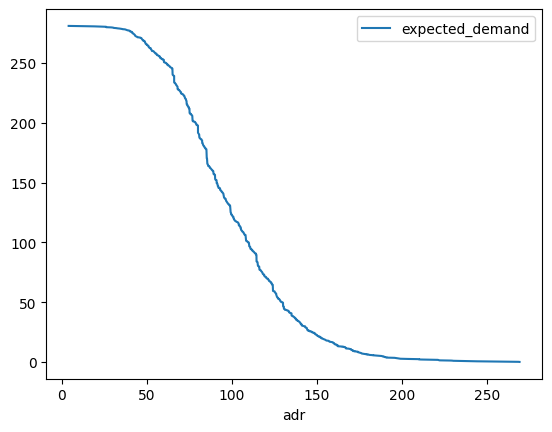

In [38]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_demand', kind='line')

<Axes: xlabel='adr'>

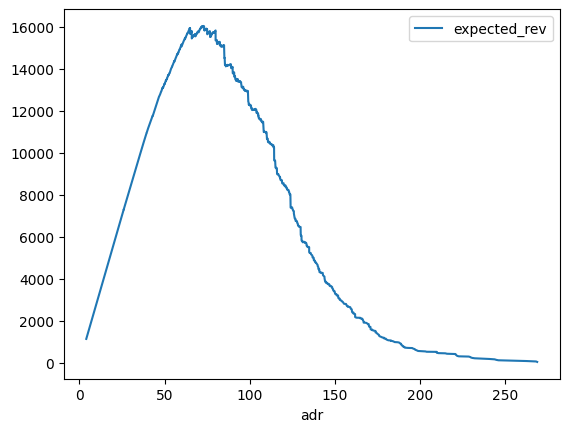

In [39]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_rev', kind='line')

In [40]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
1242,Friday,April,269.00,City Hotel,E,20.0,1,City Hotel,E,20.0,48,4.800000,5.0,0.020833,0.104167,0.104167,28.020833
1241,Friday,April,268.33,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,765,69.545455,63.0,0.001307,0.082353,0.186520,50.048806
1240,Friday,April,262.60,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,765,69.545455,63.0,0.001307,0.082353,0.268873,70.605931
1239,Friday,April,253.50,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,765,69.545455,63.0,0.001307,0.082353,0.351225,89.035662
1238,Friday,April,246.20,Resort Hotel,D,75.0,1,Resort Hotel,D,75.0,320,26.666667,26.0,0.003125,0.081250,0.432475,106.475466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102925,Wednesday,September,26.00,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0,0.001277,0.104725,320.071890,8321.869147
102924,Wednesday,September,10.00,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0,0.001277,0.104725,320.176616,3201.766157
102923,Wednesday,September,6.00,City Hotel,A,300.0,1,City Hotel,A,300.0,1372,124.727273,150.0,0.000729,0.109329,320.285945,1921.715671
102922,Wednesday,September,4.00,Resort Hotel,A,250.0,1,Resort Hotel,A,250.0,783,71.181818,82.0,0.001277,0.104725,320.390671,1281.562682


In [41]:
from scipy.optimize import curve_fit

# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d


In [42]:
x_data = merged_df['adr'].values
y_data = merged_df['expected_demand'].values


initial_guess = [1, 0.01, 1, 1, 100]
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

a_fit, b_fit, c_fit ,d_fit,max_demand= params

In [43]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

In [ ]:
plt.scatter(x_data, y_data, label='Actual Demand')
plt.plot(x_data, predicted_demand, label='Fitted Curve')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand Curve Fit')
plt.show()

In [ ]:
def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [ ]:
objective = lambda price: -revenue(price)
from scipy.optimize import minimize_scalar

result = minimize_scalar(objective, bounds=(60, 180), method='bounded')
optimal_price = result.x
max_revenue = -result.fun
room_sold = demand_curve(optimal_price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [ ]:
print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

In [ ]:
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to default price if no root is found
        price_range=(0, 200)
        price = np.random.uniform(*price_range)

    return price

# from scipy.optimize import brentq

# def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
#     def root_func(x):
#         return num_rooms - (a * np.exp(-b * x) + c)
    
#     # Find the price using numerical root finding
#     price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
#     return price

In [ ]:
demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)

In [ ]:
results = pd.DataFrame(columns=['month', 'hotel','room_limit', 'room_type', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

In [ ]:
months = merged_df.month.unique()
dow = merged_df.dow.unique()

In [ ]:
merged_df

In [ ]:
#Create a loop to observe if our demand curve fits properly to each demand month and dow


for month in months:
    for day in dow:
        
        print(month,day)
        #get data
        data = merged_df[(merged_df.dow == day) & (merged_df.month ==month)].reset_index()
        
        #remove outlier
        mean = data.adr.mean()
        std_dev = data.adr.std()
       

        # calculate z-scores
        data['z_scores'] = np.abs((data.adr - mean) / std_dev)
        
        #filter out outliers
        data = data[data.z_scores <=2]
        
        ## Fit Demand curve
        x_data = data['adr'].values
        y_data = data['expected_demand'].values
        
        # Try except expression to ensure we get no errors when fitting the demand curve due to our initial guess
        try:
            initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        except:
            if month =='January':
                
                initial_guess = [1, 0.01, 1, 1,40 ]
            else:
                initial_guess = [1, 0.01, 1, 1,50 ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        
        # Extract the fitted parameters
        a_fit, b_fit, c_fit ,d_fit,max_demand= params
        
        #visually explore if the demand curve fits the data
        predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)
        
        plt.scatter(x_data, y_data, label='Actual Demand')
        plt.plot(x_data, predicted_demand, label='Fitted Curve')
        plt.xlabel('Price')
        plt.ylabel('Demand')
        plt.legend()
        plt.title('Demand Curve Fit')
        plt.show()

In [ ]:
for hotel in hotels:
    for room_type in room_types:
        for month in months:
            for day in dow:
                # Get data for the specific combination
                data_subset = merged_df[(merged_df['dow'] == day) & 
                                        (merged_df['hotel'] == hotel) & 
                                        (merged_df['room_type'] == room_type) & 
                                        (merged_df['month'] == month)].reset_index()
                
                if data_subset.empty:
                    continue

                # Remove outliers
                mean = data_subset['adr'].mean()
                std_dev = data_subset['adr'].std()
                data_subset['z_scores'] = np.abs((data_subset['adr'] - mean) / std_dev)
                data_subset = data_subset[data_subset['z_scores'] <= 2]

                # Fit demand curve
                x_data = data_subset['adr'].values
                y_data = data_subset['expected_demand'].values

                try:
                    initial_guess = [1, 0.01, 1, 1, data_subset['total_rns_median'].values[0]]
                    bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])
                    maxfev = 10000  # Increase the number of maximum function evaluations
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess, maxfev=maxfev)
                except RuntimeError as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}, {month}, {day}: {e}")
                    continue

                a_fit, b_fit, c_fit, d_fit, max_demand = params

                # Optimize revenue
                def revenue(price):
                    return price * demand_curve(price, a_fit, b_fit, c_fit, d_fit, max_demand)

                objective = lambda price: -revenue(price)
                optimize = minimize_scalar(objective, bounds=(45, 200), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun
                expected_rns = demand_curve(optimal_price, a_fit, b_fit, c_fit, d_fit, max_demand)

                optimal_rate_lim_inv = demand_to_price(data_subset['room_limit'].mean(), a_fit, b_fit, c_fit, d_fit, max_demand)

                new_row = pd.DataFrame({'hotel': hotel,
                                        'room_type': room_type,
                                        'room_limit': data_subset['room_limit'].mean(),
                                        'month': month,
                                        'dow': day,
                                        'optimal_rate': optimal_price,
                                        'expected_rev': max_revenue,
                                        'expected_rn': expected_rns,
                                        'optimal_rate_lim_inv': optimal_rate_lim_inv}, index=[0])
                results = pd.concat([results, new_row], ignore_index=True)


In [ ]:
results

In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sort the dataframe by the custom order
results['month'] = pd.Categorical(results['month'], categories=month_order, ordered=True)
results['dow'] = pd.Categorical(results['dow'], categories=dow_order, ordered=True)
results = results.sort_values(['month', 'dow'])

grouped = results.groupby(['month', 'dow'])['optimal_rate'].mean().unstack()

# Create the graph
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(ax=ax, kind='bar')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Optimal Rate')
ax.set_title('Optimal Rate by Month and Day of the Week')

# Customize the appearance (optional)
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

# Show the graph
plt.show()

In [ ]:
#clean up the results
results['optimal_rate'] = results['optimal_rate'].round()
results['optimal_rate_lim_inv'] = results['optimal_rate_lim_inv'].round()

results['expected_rn'] = results['expected_rn'].round().astype(int)
results['expected_rev'] = results['expected_rev'].round()
results

# Holidays

In [ ]:
holidays =  expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) != 0]
holidays

In [ ]:
unpivoted = pd.melt(holidays, id_vars=['arrival_date', 'total_rns', 'adr', 'dow', 'month', "hotel", "room_type", 'room_limit'],
                    value_vars=['new_year', 'easter', 'christmas'],
                    var_name='holiday', value_name='holiday_indicator')

In [ ]:
unpivoted[unpivoted.holiday =='christmas']
unpivoted = unpivoted[unpivoted['holiday_indicator'] == 1]
unpivoted

In [ ]:
holiday_adr = unpivoted.groupby(['holiday','adr','holiday_indicator', "hotel", "room_type"]).agg({'room_limit': 'mean', 'total_rns':'sum'}).reset_index()
holiday_rns = unpivoted.groupby(['arrival_date','holiday', "hotel", "room_type"]).agg({'room_limit': 'mean','total_rns':'sum'}).reset_index()
holiday_rns = holiday_rns.groupby(['holiday', "hotel", "room_type"]).agg({'room_limit': 'mean', 'total_rns':['sum','mean','median']}).reset_index()
holiday_rns.columns = ['_'.join(col) for col in holiday_rns.columns]

In [ ]:
holiday_rns

In [ ]:
merged_holidays = pd.merge(holiday_adr, holiday_rns,how='left',left_on=['holiday' ,'hotel', 'room_type'], right_on=['holiday_' ,'hotel_', 'room_type_'],suffixes=('_act', '_tot'))

merged_holidays.drop('holiday_',axis=1,inplace=True)

merged_holidays

In [ ]:
merged_holidays['probability'] = merged_holidays['total_rns']/merged_holidays['total_rns_sum']
merged_holidays['expected_rns'] = merged_holidays['probability'] * merged_holidays['total_rns_median']
merged_holidays = merged_holidays.sort_values(by=['holiday', 'adr'], ascending=[True, False])
merged_holidays['expected_demand']=merged_holidays.groupby(['holiday'])['expected_rns'].cumsum()

In [ ]:
merged_holidays

In [ ]:
unique_holidays = merged_holidays.holiday.unique()


In [ ]:
def demand_to_price(num_rooms, a, b, c, d, max_demand):
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to default price if no root is found
        price_range=(0, 200)
        price = np.random.uniform(*price_range)

    return price

In [ ]:
holiday_results = pd.DataFrame(columns=['holiday', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

for hotel in hotels:
    for room_type in room_types:

        for day in unique_holidays:
                data = merged_holidays[(merged_holidays.holiday == day) & (merged_holidays.hotel == hotel) & (merged_holidays.room_type == room_type) ].reset_index()

                #remove outlier
                mean = data.adr.mean()
                std_dev = data.adr.std()


                # calculate z-scores
                data['z_scores'] = np.abs((data.adr - mean) / std_dev)

                #filter out outliers
                data = data[data.z_scores <=2]

                ## Fit Demand curve
                x_data = data['adr'].values
                y_data = data['expected_demand'].values

                initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
                bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

                try:
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
                except Exception as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}: {e}")
                    continue

                # Extract the fitted parameters
                a_fit, b_fit, c_fit ,d_fit,max_demand= params

                a_fit, b_fit, c_fit ,d_fit,max_demand = np.round(a_fit, 3), np.round(b_fit, 3), np.round(c_fit, 3) ,np.round(d_fit, 3),np.round(max_demand, 3)
                #optimze revenue
                objective = lambda price: -revenue(price)



                optimize = minimize_scalar(objective, bounds=(45, 400), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun

                expected_rns = demand_curve(optimal_price,a_fit, b_fit, c_fit ,d_fit,max_demand)
                print(50,a_fit,b_fit,c_fit,d_fit,max_demand)
                optimal_rate_lim_inv = demand_to_price(data.room_limit.mean() ,a_fit,b_fit,c_fit,d_fit,max_demand)

                new_row = pd.DataFrame({'holiday':day,
                                        'hotel': hotel,
                                        'room_limit': data.room_limit.mean(),
                               'room_type': room_type,
                               'optimal_rate': optimal_price,
                               'expected_rev':max_revenue,
                               'expected_rn':expected_rns,
                               'optimal_rate_lim_inv':optimal_rate_lim_inv},index=[0])
                holiday_results = pd.concat([holiday_results, new_row], ignore_index=True)

In [ ]:
 data_subset['total_rns_median'].values[0]

In [ ]:
holiday_results

In [ ]:
results

In [ ]:
room_types

In [ ]:
holiday_results


years = [2020, 2021, 2022, 2023]

holiday_dates = []
for year in years:
    for index, row in holiday_results.iterrows():
        if row['holiday'] == 'christmas':
            date = datetime.date(year, 12, 25)
        elif row['holiday'] == 'easter':
            date = easter(year)
        elif row['holiday'] == 'new_year':
            date = datetime.date(year, 1, 1)

        holiday_dates.append({
            'hotel': row['hotel'],
            'room_type': row['room_type'],
            'month': date.strftime('%B'),
            'dow': date.strftime("%A"),
            'holiday': row['holiday'],
            'optimal_rate': row['optimal_rate'],
            'expected_rn': row['expected_rn'],
            'expected_rev': row['expected_rev'],
            'optimal_rate_lim_inv': row['optimal_rate_lim_inv'],
            'arrival_date': pd.to_datetime(date)
        })

holiday_results_yearly = pd.DataFrame(holiday_dates)




In [ ]:
holiday_results_yearly[holiday_results_yearly.holiday == 'new_year']

In [ ]:
results[(results['month'] == 'April') & (results['room_type'] == 'A')]

In [ ]:
import itertools

hotel_types = ['Resort Hotel', 'City Hotel']
room_types = ['A', 'D', 'E']

combinations = list(itertools.product(hotel_types, room_types))

combinations

combinations_df = pd.DataFrame(combinations, columns=['hotel', 'room_type'])
combinations_df

In [ ]:
month_dict = {month: index for index, month in enumerate(pd.date_range('2020-01-01', periods=12, freq='M').strftime('%B'), 1)}


new_data = pd.DataFrame()

for year in range(2020, 2024):
    for month in month_dict.values():
        start_date = pd.to_datetime(f'{year}-{month}-01').replace(day=1)
        end_date = pd.to_datetime(f'{year}-{month}-01').replace(day=1) + pd.offsets.MonthEnd(0)
        date_range = pd.date_range(start_date, end_date, freq='D')
        df = pd.DataFrame(date_range, columns=['arrival_date'])
        df['dow'] = df['arrival_date'].dt.day_name()
        df['month'] = df['arrival_date'].dt.month_name()

        result_df = df.assign(key=1).merge(combinations_df.assign(key=1), on='key').drop('key', axis=1)
        new_data = pd.concat([new_data, result_df], ignore_index=True)
new_data

In [ ]:
final_data = pd.merge(new_data, results, how='left', on=['dow', 'hotel', 'room_type', 'month'])
final_data

In [ ]:
holiday_results_yearly['arrival_date'] = pd.to_datetime(holiday_results_yearly['arrival_date'])
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [ ]:
merged_df = pd.merge(final_data, holiday_results_yearly[['arrival_date', 'hotel', 'room_type', 'month', 'dow', 'optimal_rate', 'expected_rn', 'expected_rev', 'optimal_rate_lim_inv']], how='left', on=['arrival_date', 'hotel','room_type','month'], suffixes=('', '_holiday'))
merged_df

In [ ]:
merged_df[merged_df.arrival_date == '2020-01-01']

In [ ]:
final_data['optimal_rate'] = merged_df['optimal_rate_holiday'].combine_first(final_data['optimal_rate'])
final_data['expected_rn'] = merged_df['expected_rn_holiday'].combine_first(final_data['expected_rn'])
final_data['expected_rev'] = merged_df['expected_rev_holiday'].combine_first(final_data['expected_rev'])
final_data['optimal_rate_lim_inv'] = merged_df['optimal_rate_lim_inv_holiday'].combine_first(final_data['optimal_rate_lim_inv'])


In [ ]:
final_data.isna().sum()

In [ ]:
final_data

In [ ]:
data_backup['arrival_date_transformed'] = pd.to_datetime(data_backup['arrival_date_transformed'])
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [ ]:
rev_opt_booking = pd.merge(data_backup, final_data, right_on=['arrival_date', 'hotel', 'room_type'], left_on=['arrival_date_transformed', 'hotel', 'reserved_room_type'], how='left')
rev_opt_booking.to_csv('rev_opt_booking.csv', index=False)

In [ ]:
rev_opt_booking

In [ ]:
rev_opt_booking.drop(['month_y', 'room_limit_y'], axis=1, inplace=True)

In [ ]:
rev_opt_booking.rename(columns={"month_x": 'month', 'room_limit_x': 'room_limit'}, inplace=True)

In [ ]:
rev_opt_booking["arrival_data"] = pd.to_datetime(rev_opt_booking["arrival_date"])
rev_opt_booking["arrival_date_transformed"] = pd.to_datetime(rev_opt_booking["arrival_date_transformed"])

In [ ]:
rev_opt_booking.columns = map(lambda x: str(x).lower(), rev_opt_booking.columns)


In [ ]:
rev_opt_booking.rename(columns={'arrival_date_year':'year',
                                'optimal_rate' : 'optimal_adr', 'optimal_rate_lim_inv': 'optimal_adr_limited',
                                'transcation_ids': 'booking_id', 'reservation_status_date_transformed': 'reservation_date'
                               }, inplace=True)

In [ ]:
rev_opt_booking.info()

In [ ]:
rev_opt_booking['room_limit'] = rev_opt_booking.apply(update_values, axis=1)

In [ ]:
rev_opt_booking = rev_opt_booking.drop([ 'reservation_status_date',  'avg_rooms_per_night','reserved_room_type', 'tally_days', 'total_room_nights'], axis=1)

In [ ]:
rev_opt_booking.columns

In [ ]:
rev_opt_booking['adr'] = rev_opt_booking['adr'].astype(int)

In [ ]:
rev_opt_booking = rev_opt_booking[['arrival_date', 'hotel', 'adr', 'is_canceled', 'lead_time',  'babies', 'children', 'country', 'customer_type',  'cust_id', 'days_in_waiting_list', 'deposit_type', 'distribution_channel', 'dow', 'expected_rev','expected_rn', 'market_segment', 'meal', 'month', 'optimal_adr',  'optimal_adr_limited', 'previous_bookings_not_canceled', 'previous_cancellations', 'reservation_status','reservation_date', 'room_type', 'room_limit', 'stays_in_weekend_nights', 'stays_in_week_nights',  'total_guests', 'total_stay_nights', 'booking_id']]

In [ ]:
rev_opt_booking

In [ ]:
rev_opt_booking["reservation_date"] = pd.to_datetime(rev_opt_booking["reservation_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")
rev_opt_booking["arrival_date"] = pd.to_datetime(rev_opt_booking["arrival_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")

rev_opt_booking["reservation_date"]

In [ ]:
rev_opt_booking["arrival_date"]

In [ ]:
df_model=session.createDataFrame(
        rev_opt_booking.values.tolist(),
        schema=rev_opt_booking.columns.tolist())
df_model.write.mode("overwrite").save_as_table("TTH_DB.TTH_REV_OPT_Schema.REV_OPT_OUTPUT")

In [ ]:
rev_opt_booking.columns

In [ ]:
rev_opt_booking.info()

In [ ]:
def update_values(row):
    if row['hotel'] == 'City Hotel' and row['room_type'] == 'A':
        return 300
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'E':
        return 20
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'A':
        return 250
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'E':
        return 60
    else:
        pass

In [ ]:
rev_opt_booking['room_limit'] = rev_opt_booking.apply(update_values, axis=1)

In [ ]:
rev_opt_booking.sample(n=7)

In [ ]:
rev_opt_booking.sample(n=8)[['expected_rn', 'room_limit', 'optimal_adr', 'optimal_adr_limited']]